In [38]:
import random
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import Word
import pandas as pd
import string as st
from nltk import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
import nltk

nltk.download('all')

In [97]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    #text = text.translate(str.maketrans('', '', st.punctuation))
    text = remove_punct(text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply PorterStemmer
    #porter_stemmer = PorterStemmer()
    #tokens = [porter_stemmer.stem(word) for word in tokens]

    # Apply WordNetLemmatizer
    #wordnet_lemmatizer = WordNetLemmatizer()
    #tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a single string
    clean_text = ' '.join(tokens)

    return clean_text.strip()

# Text cleaning and dataset preparation

In [98]:
def prepare_dataset(dataset):
    #Divide in features and labels. We're gonna do a tokenization and lemmatization process with the news features
    x = dataset['news'].tolist()
    y = dataset['type'].tolist()
    wordnet_lemmatizer = WordNetLemmatizer()
    print("Data preparation")
    print("Tokenization and Lemmatization process", end='', flush=True)
    for i, value in enumerate(x):
        x[i] = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in clean_text(value).split()])
        
    
    #Train and test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    vect = TfidfVectorizer(min_df=2)

    #Training process
    X_train = vect.fit_transform(X_train)
    y_train = np.array(y_train)
    X_test = vect.transform(X_test)
    y_test = np.array(y_test)

    #Train and test split with the vector
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    print("\n")
    print("Train set:" + str(X_train.shape))
    print("Validation set:" + str(X_val.shape))
    print("Test set:" + str(X_test.shape))

    return X_train, X_val, X_test, y_train, y_val, y_test, vect

# Process for knowing how many neighbors we may use in the K-neighbors

In [99]:
dataset2 = pd.read_csv('./datasets/profile_dataset2.csv', encoding="ISO-8859-1")
y = dataset2['type'] #Variable objetivo a predecir
X = dataset2.drop("type", axis = 1) #Quitar la columna de vehicle_class
X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(dataset2)

Data preparation
Tokenization and Lemmatization process

Train set:(1952, 15235)
Validation set:(244, 15235)
Test set:(244, 15235)


In [100]:
#Process for knowing how many neighbors we may use
error_rate = []
for x in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=x)
    knn.fit(X_train, y_train)
    predictions_x = knn.predict(X_test)
    #Agregar la media de los valores que encuentre diferente entre las predicciones y el valor real. 
    error_rate.append(np.mean(predictions_x != y_test))
    
error_rate

[0.09836065573770492,
 0.11475409836065574,
 0.10655737704918032,
 0.0942622950819672,
 0.0860655737704918,
 0.09836065573770492,
 0.09836065573770492,
 0.09836065573770492,
 0.09836065573770492,
 0.0942622950819672,
 0.09016393442622951,
 0.0860655737704918,
 0.0942622950819672,
 0.09016393442622951,
 0.09836065573770492,
 0.09016393442622951,
 0.09016393442622951,
 0.09836065573770492,
 0.10245901639344263,
 0.09016393442622951,
 0.0778688524590164,
 0.0778688524590164,
 0.06557377049180328,
 0.07377049180327869,
 0.0778688524590164,
 0.08196721311475409,
 0.0778688524590164,
 0.0860655737704918,
 0.0860655737704918]

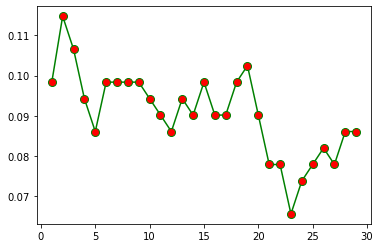

In [101]:
values = range(1,30)
plt.plot(values, error_rate, color = "green", marker="o", markerfacecolor="red", markersize=8)

# Models functions

In [102]:
def NN_train_model(X_train, y_train):
    print("\nNeural Network")
    model = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True,
              epsilon=1e-08, hidden_layer_sizes=(128, 64),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=400, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
    model.fit(X_train, y_train)
    return model

def RF_train_model(X_train, y_train):
    print("\nRandom Forest")
    model = RandomForestClassifier(n_estimators=200, max_depth=150, n_jobs=1)
    model.fit(X_train, y_train)
    return model

def SVC_train_model(X_train, y_train):
    print("\nSuport Vector Machine")
    model = SVC(kernel='linear', gamma='auto')
    model.fit(X_train, y_train)
    return model

def KN_train_model(X_train, y_train):
    print("\nK Neighbor")
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def evaluation_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    result = classification_report(y_val, y_pred)
    accSVC = accuracy_score(y_val, y_pred)
    print(result)
    print("\nAccuracy: ", accSVC)


def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc




# Set users preferences

In [103]:
topics = ["sport", "tech", "business", "politics", "entertainment"]

# Set preferences by users
def set_preferences(users):
    user_preferences = {}
    for user in users:
        preferences = []
        possibilities = list(topics)
        for pref in range(random.randint(1, 3)):
            category = random.choice(possibilities)
            preferences.append(category)
            possibilities.remove(category)
        user_preferences[user] = preferences
    return user_preferences

# Predict the document type
def predict_doc_type(doc, vect, model):
    document_cleaned = clean_text(doc)
    corpus = []
    corpus.append(document_cleaned)
    test_vect = vect.transform(corpus)
    return model.predict(test_vect)[0]


# Testing results
def run_test(vect, model):
    users = ["Gabriela", "Pablo", "Erick", "Marco", "Sam", "Luis"]
    users_preferences = set_preferences(users)
    print("\n")
    print("User preferences:")
    for user in users_preferences:
        print(user, "likes these topics:", users_preferences[user])
    print("\n")

    while True:
        try:
            test_corpus = input("Enter a text about a specific tpic. If you wanna quit, please press 'e' or if you wanna reassign the preferences please press 'a':\n")
        except ValueError:
            continue
        if test_corpus == "e":
            break
        if test_corpus == "a":
            users_preferences = set_preferences(users)
            print("\n")
            print("User preferences:")
            for user in users_preferences:
                print(user, "likes these topics:", users_preferences[user])
            print("\n")
            continue
            
        else:

            result = predict_doc_type(test_corpus, vect, model)
            if (result == "sport"):
                topic = result.upper()
            if (result == "tech"):
                topic = result.upper()
            if(result == "business"):
                topic = result.upper()
            if (result == "entertainment"):
                topic = result.upper()
            if (result == "politics"):
                topic = result.upper()
            print("\n")
            print("This article talks about "+ topic + " " + "and it's addressed to:")
            for user in users_preferences:
                if result in users_preferences[user]:
                    print(user)
            continue

In [104]:
def test_project():
    # Load dataset and data preparation
    dataset = pd.read_csv('./datasets/profile_dataset2.csv', encoding="ISO-8859-1")
    print("Data", dataset.shape)
    X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(dataset)

    # Models training
    print("\n")
    print("Models Training")
    
    # Suport Vector Machine
    svc_model = SVC_train_model(X_train, y_train)
    evaluation_model(svc_model, X_val, y_val)
    # Random Forest
    rf_model = RF_train_model(X_train, y_train)
    evaluation_model(rf_model, X_val, y_val)
    # Neural Network
    nn_model = NN_train_model(X_train, y_train)
    evaluation_model(nn_model, X_val, y_val)
    # K Neighbor
    kn_model = KN_train_model(X_train, y_train)
    evaluation_model(kn_model, X_val, y_val)


    # Models testing
    print("\n")
    print("Models testing\n")
    print("Suport Vector Machine:", test_model(svc_model, X_test, y_test))
    print("Random Forest:", test_model(rf_model, X_test, y_test))
    print("Neural Network:", test_model(nn_model, X_test, y_test))
    print("K Neighbors:", test_model(kn_model, X_test, y_test))


    # Run test
    #We pass the vector and any model we have trained
    run_test(vect, svc_model)


In [105]:
test_project()

Data (2440, 2)
Data preparation
Tokenization and Lemmatization process

Train set:(1952, 15235)
Validation set:(244, 15235)
Test set:(244, 15235)


Models Training

Suport Vector Machine
               precision    recall  f1-score   support

     business       0.97      0.92      0.94        63
entertainment       0.97      0.95      0.96        39
     politics       0.89      0.98      0.93        41
        sport       0.98      0.98      0.98        58
         tech       0.95      0.95      0.95        43

     accuracy                           0.95       244
    macro avg       0.95      0.96      0.95       244
 weighted avg       0.96      0.95      0.96       244


Accuracy:  0.9549180327868853

Random Forest
               precision    recall  f1-score   support

     business       0.96      0.87      0.92        63
entertainment       0.97      0.95      0.96        39
     politics       0.93      0.98      0.95        41
        sport       0.95      0.97      0.96    

KeyboardInterrupt: Interrupted by user